## Milton Crash Data Analysis

In [1]:
import pandas as pd
import folium
from IPython.display import HTML
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx
import milton_maps as mm
import seaborn as sns

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
town_boundaries = gpd.read_file("../data/processed/town_boundaries.shp.zip").set_index("TOWN_ID")
milton_boundaries = town_boundaries[town_boundaries.TOWN.isin(["MILTON"])]

In [3]:
crash_data = pd.read_excel("../data/raw/CrashDetails_cwzqv2fitj4m5ovin0xrkq11.xls", skiprows=6)
crash_data.shape

WARNING *** file size (3678144) not 512 + multiple of sector size (512)


(4571, 28)

In [4]:
crash_data.head(10)

RMV Crash Number City Town Name   Crash Date Crash Time  \
0          4136317         MILTON  01-Jan-2016    2:50 AM   
1          4138031         MILTON  03-Jan-2016    2:30 AM   
2          4170301         MILTON  03-Jan-2016    3:08 AM   
3          4170346         MILTON  03-Jan-2016   11:28 AM   
4          4170384         MILTON  03-Jan-2016    6:47 PM   
5          4170300         MILTON  04-Jan-2016    7:36 AM   
6          4172349         MILTON  05-Jan-2016   12:02 AM   
7          4170299         MILTON  05-Jan-2016    8:43 AM   
8          4172298         MILTON  05-Jan-2016    2:47 PM   
9          4172293         MILTON  06-Jan-2016    5:39 AM   

                        Crash Severity       Maximum Injury Severity Reported  \
0  Property damage only (none injured)                              No injury   
1  Property damage only (none injured)                              No injury   
2  Property damage only (none injured)                              No injury   
3  Property damage only (none injured)                              No injury   
4  Property damage only (none injured)                              No injury   
5                     Non-fatal injury            Non-fatal injury - Possible   
6  Property damage only (none injured)                              No injury   
7  Property damage only (none injured)                              No injury   
8  Property damage only (none injured)                              No injury   
9                     Non-fatal injury  Non-fatal injury - Non-incapacitating   

   Number of Vehicles  Total Nonfatal Injuries  Total Fatal Injuries  \
0                 2.0                      0.0                   0.0   
1                 1.0                      0.0                   0.0   
2                 3.0                      0.0                   0.0   
3                 2.0                      0.0                   0.0   
4                 1.0                      0.0                   0.0   
5                 3.0                      3.0                   0.0   
6                 1.0                      0.0                   0.0   
7                 3.0                      0.0                   0.0   
8                 2.0                      0.0                   0.0   
9                 2.0                      2.0                   0.0   

         Manner of Collision  ...               Ambient Light  \
0  Sideswipe, same direction  ...      Dark - lighted roadway   
1       Single vehicle crash  ...  Dark - roadway not lighted   
2  Sideswipe, same direction  ...      Dark - lighted roadway   
3                   Rear-end  ...                    Daylight   
4       Single vehicle crash  ...      Dark - lighted roadway   
5                   Rear-end  ...                    Daylight   
6       Single vehicle crash  ...      Dark - lighted roadway   
7                   Rear-end  ...                    Daylight   
8  Sideswipe, same direction  ...                    Daylight   
9                   Rear-end  ...      Dark - lighted roadway   

  Weather Condition                         At Roadway Intersection  \
0             Clear                                             NaN   
1            Cloudy                                             NaN   
2       Clear/Clear                  REEDSDALE ROAD / THOMPSON LANE   
3            Cloudy                                             NaN   
4       Clear/Clear                                             NaN   
5            Cloudy                                             NaN   
6             Clear                RANDOLPH AVENUE / REEDSDALE ROAD   
7             Clear                                             NaN   
8             Clear  BRUSH HILL ROAD / BLUE HILL AVENUE Rte SR138 S   
9             Clear                  BLUE HILL AVENUE / DOLLAR LANE   

       Distance From Nearest Roadway Intersection  \
0                              Rte 93 S / UNKNOWN   
1                   UNQUITY ROAD / HARLAN

Data transformation notes:

* Need to parse Crash Date + Crash Time into a datetime field.
* Transform Crash Severity into a categorical variable.
* Transform Manner of Collission into a categorical variable.

In [5]:
print(f"{crash_data[crash_data['X Cooordinate'].isnull()].shape[0]} records are missing coordinates.  We'll drop these for now.")

310 records are missing coordinates.  We'll drop these for now.


In [6]:
crash_data = crash_data[~crash_data['X Cooordinate'].isnull()]

In [7]:
geometry = [Point(row['X Cooordinate'], row['Y Cooordinate']) for i, row in crash_data.iterrows()]

In [8]:
crash_geodf = gpd.GeoDataFrame(data=crash_data, geometry=geometry, crs="EPSG:26986")

In [ ]:
fig, ax = plt.subplots(1, figsize=(20,20))
ax = mm.plot_map(crash_geodf,
                 column="Maximum Injury Severity Reported",
                 categorical=True,
                 markersize=30,
                 alpha=0.75,
                 ax=ax
                 )

ctx.add_basemap(ax, crs="EPSG:26986")

Questions:

* How to identify accidents along Randolph Avenue?

In [10]:
injury_map = {
     'No injury': 'No Injury',
     'Non-fatal injury - Possible': 'Minor Injury',
     'Non-fatal injury - Non-incapacitating': 'Minor Injury',
     'Non-fatal injury - Incapacitating': "Major Injury",
     'Not reported': "Unknown",
     'Fatal injury (K)': "Fatal Injury",
     'Unknown': "Unknown",
     'Not Applicable': "No Injury",
     'Deceased not caused by crash': "No Injury",
     'No Apparent Injury (O)': "No Injury",
     'Suspected Minor Injury (B)': "Minor Injury",
     'Possible Injury (C)': "Minor Injury",
     'Suspected Serious Injury (A)': "Major Injury",
}

crash_geodf['severity'] = crash_geodf['Maximum Injury Severity Reported'].fillna("Unknown").map(injury_map)

In [11]:
colormap = {
    "Unknown": "gray",
    "No Injury": "blue",
    "Minor Injury": "yellow",
    "Major Injury": "orange",
    "Fatal Injury": "red",
}

In [12]:
crash_geodf.columns

Index(['RMV Crash Number', 'City Town Name', 'Crash Date', 'Crash Time',
       'Crash Severity', 'Maximum Injury Severity Reported',
       'Number of Vehicles', 'Total Nonfatal Injuries', 'Total Fatal Injuries',
       'Manner of Collision', 'Unnamed: 10', 'Vehicle Action Prior to Crash',
       'Vehicle Travel Directions', 'Unnamed: 13', 'Unnamed: 14',
       'Most Harmful Events', 'Vehicle Configuration',
       'Road Surface Condition', 'Ambient Light', 'Weather Condition',
       'At Roadway Intersection', 'Distance From Nearest Roadway Intersection',
       'Distance From Nearest Milemarker', 'Distance From Nearest Exit',
       'Distance From Nearest Landmark', 'Non Motorist Type', 'X Cooordinate',
       'Y Cooordinate', 'geometry', 'severity'],
      dtype='object')

In [13]:
map_center = milton_boundaries.to_crs("EPSG:4326").loc[189].geometry.centroid
milton_map = folium.Map(width=800,height=800, location=[map_center.y, map_center.x], zoom_start=13)

for i, row in crash_geodf.to_crs("EPSG:4326").iterrows():
    folium.CircleMarker(
        (row.geometry.y, row.geometry.x),
        radius=5,
        color=colormap[row['severity']],
        popup=folium.Popup(f"""
        Crash Date: {row['Crash Date']}<br>
        Crash Time: {row['Crash Time']}<br>
        Weather Conditions: {row['Weather Condition']}<br>
        Maximum Injury Severity Reported: {row['Maximum Injury Severity Reported']}
        """
        )
    ).add_to(milton_map)
display(milton_map)

In [14]:
crash_geodf.head()

RMV Crash Number City Town Name   Crash Date Crash Time  \
0          4136317         MILTON  01-Jan-2016    2:50 AM   
1          4138031         MILTON  03-Jan-2016    2:30 AM   
2          4170301         MILTON  03-Jan-2016    3:08 AM   
3          4170346         MILTON  03-Jan-2016   11:28 AM   
4          4170384         MILTON  03-Jan-2016    6:47 PM   

                        Crash Severity Maximum Injury Severity Reported  \
0  Property damage only (none injured)                        No injury   
1  Property damage only (none injured)                        No injury   
2  Property damage only (none injured)                        No injury   
3  Property damage only (none injured)                        No injury   
4  Property damage only (none injured)                        No injury   

   Number of Vehicles  Total Nonfatal Injuries  Total Fatal Injuries  \
0                 2.0                      0.0                   0.0   
1                 1.0                      0.0                   0.0   
2                 3.0                      0.0                   0.0   
3                 2.0                      0.0                   0.0   
4                 1.0                      0.0                   0.0   

         Manner of Collision  ...         At Roadway Intersection  \
0  Sideswipe, same direction  ...                             NaN   
1       Single vehicle crash  ...                             NaN   
2  Sideswipe, same direction  ...  REEDSDALE ROAD / THOMPSON LANE   
3                   Rear-end  ...                             NaN   
4       Single vehicle crash  ...                             NaN   

  Distance From Nearest Roadway Intersection Distance From Nearest Milemarker  \
0                         Rte 93 S / UNKNOWN                              NaN   
1              UNQUITY ROAD / HARLAND STREET                              NaN   
2             REEDSDALE ROAD / THOMPSON LANE                              NaN   
3                1249 RANDOLPH AVENUE Rte 28                              NaN   
4                       1043 RANDOLPH AVENUE                              NaN   

   Distance From Nearest Exit  Distance From Nearest Landmark  \
0          Exit 9 on Rte 93 S                             NaN   
1                         NaN                      CAMP SAYRE   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

  Non Motorist Type  X Cooordinate  Y Cooordinate  \
0               NaN  237954.181333  889568.707045   
1               NaN  233823.778861  887239.065913   
2               NaN  234704.583122  889639.264997   
3               NaN  235426.833031  886303.215857   
4               NaN  235455.851915  887025.734960   

                        geometry   severity  
0  POINT (237954.181 889568.707)  No Injury  
1  POINT (233823.779 887239.066)  No Injury  
2  POINT (234704.583 889639.265)  No Injury  
3  POINT (235426.833 886303.216)  No Injury  
4  POINT (235455.852 887025.735)  No Injury  

[5 rows x 30 columns]

In [15]:
crash_geodf['crash_time'] = pd.to_datetime(crash_geodf['Crash Date'] + " " + crash_geodf['Crash Time'])

In [16]:
crash_geodf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4261 entries, 0 to 4568
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   RMV Crash Number                            4261 non-null   object        
 1   City Town Name                              4261 non-null   object        
 2   Crash Date                                  4261 non-null   object        
 3   Crash Time                                  4261 non-null   object        
 4   Crash Severity                              4261 non-null   object        
 5   Maximum Injury Severity Reported            4261 non-null   object        
 6   Number of Vehicles                          4261 non-null   float64       
 7   Total Nonfatal Injuries                     4261 non-null   float64       
 8   Total Fatal Injuries                        4261 non-null   float64       
 9   Manne

In [17]:
roads_df = gpd.read_file("../data/raw/MassDOT_Roads_SHP/EOTMAJROADS_RTE_MAJOR.shp")

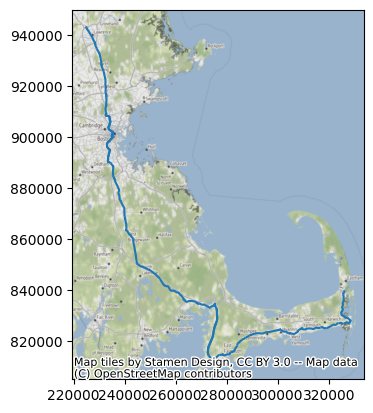

In [18]:
ax = roads_df[roads_df.RT_NUMBER=="28"].plot()
ctx.add_basemap(ax, crs="EPSG:26986")

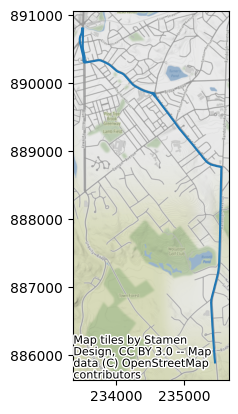

In [19]:
rt28 = roads_df[roads_df.RT_NUMBER=="28"]
milton_rt_28 = gpd.clip(rt28, milton_boundaries)
ax = milton_rt_28.plot()
ctx.add_basemap(ax, crs="EPSG:26986")

In [20]:
df_nearest_major_road = gpd.sjoin_nearest(crash_geodf, roads_df, how="left", distance_col="distance_to_major_road")

In [21]:
df_nearest_major_road.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7884 entries, 0 to 4568
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   RMV Crash Number                            7884 non-null   object        
 1   City Town Name                              7884 non-null   object        
 2   Crash Date                                  7884 non-null   object        
 3   Crash Time                                  7884 non-null   object        
 4   Crash Severity                              7884 non-null   object        
 5   Maximum Injury Severity Reported            7884 non-null   object        
 6   Number of Vehicles                          7884 non-null   float64       
 7   Total Nonfatal Injuries                     7884 non-null   float64       
 8   Total Fatal Injuries                        7884 non-null   float64       
 9   Manne

In [22]:
rt_28_crashes = df_nearest_major_road[(df_nearest_major_road.RT_NUMBER=="28") & (df_nearest_major_road.distance_to_major_road < 10.0)]
rt_28_crashes

RMV Crash Number City Town Name   Crash Date Crash Time  \
2             4170301         MILTON  03-Jan-2016    3:08 AM   
3             4170346         MILTON  03-Jan-2016   11:28 AM   
4             4170384         MILTON  03-Jan-2016    6:47 PM   
6             4172349         MILTON  05-Jan-2016   12:02 AM   
8             4172298         MILTON  05-Jan-2016    2:47 PM   
...               ...            ...          ...        ...   
4469          5138218         MILTON  03-Aug-2022   12:59 AM   
4484          5154451         MILTON  11-Aug-2022    8:48 AM   
4506          5143294         MILTON  20-Aug-2022    4:31 PM   
4523          5144478         MILTON  30-Aug-2022    5:15 PM   
4544          5157351         MILTON  26-Sep-2022    1:11 AM   

                           Crash Severity Maximum Injury Severity Reported  \
2     Property damage only (none injured)                        No injury   
3     Property damage only (none injured)                        No injury   
4     Property damage only (none injured)                        No injury   
6     Property damage only (none injured)                        No injury   
8     Property damage only (none injured)                        No injury   
...                                   ...                              ...   
4469  Property damage only (none injured)           No Apparent Injury (O)   
4484                     Non-fatal injury       Suspected Minor Injury (B)   
4506  Property damage only (none injured)           No Apparent Injury (O)   
4523  Property damage only (none injured)           No Apparent Injury (O)   
4544  Property damage only (none injured)           No Apparent Injury (O)   

      Number of Vehicles  Total Nonfatal Injuries  Total Fatal Injuries  \
2                    3.0                      0.0                   0.0   
3                    2.0                      0.0                   0.0   
4                    1.0                      0.0                   0.0   
6                    1.0                      0.0                   0.0   
8                    2.0                      0.0                   0.0   
...                  ...                      ...                   ...   
4469                 1.0                      0.0                   0.0   
4484                 2.0                      0.0                   0.0   
4506                 2.0                      0.0                   0.0   
4523                 2.0                      0.0                   0.0   
4544                 1.0                      0.0                   0.0   

            Manner of Collision  ...  X Cooordinate  Y Cooordinate  \
2     Sideswipe, same direction  ...  234704.583122  889639.264997   
3                      Rear-end  ...  235426.833031  886303.215857   
4          Single vehicle crash  ...  235455.851915  887025.734960   
6          Single vehicle crash  ...  235553.115602  888768.223461   
8     Sideswipe, same direction  ...  233466.280912  890649.454822   
...                         ...  ...            ...            ...   
4469       Single vehicle crash  ...  233513.001100  890673.026900   
4484                      Angle  ...  233608.430200  890315.144300   
4506                   Rear-end  ...  233511.265594  890591.182415   
4523                      Angle  ...  233520.676606  890363.794546   
4544       Single vehicle crash  ...  233466.281100  890649.455000   

                           geometry      severity          crash_time  \
2     POINT (234704.583 889639.265)     No Injury 2016-01-03 03:08:00   
3     POINT (235426.833 886303.216)     No Injury 2016-01-03 11:28:00   
4     POINT (235455.852 887025.735)     No Injury 2016-01-03 18:47:00   
6     POINT (235553.116 888768.223)     No Injury 2016-01-05 00:02:00   
8     POINT (233466.281 890649.455)     No Injury 2016-01-05 14:47:00   
...                             ...           ...                 ...   
4469  POINT (233513.001 890673.027)     No Inj

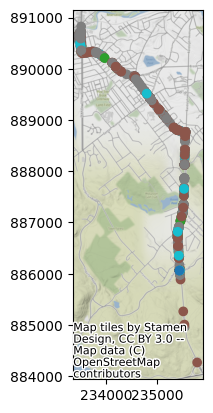

In [23]:
ax = rt_28_crashes.plot(column="severity")
ctx.add_basemap(ax, crs="EPSG:26986")

In [24]:
rt_28_crashes['month_year'] = rt_28_crashes['crash_time'].dt.to_period('M')

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/milton-maps-gfMaDXEA-py3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
df = rt_28_crashes.groupby(["month_year", "severity"])['RMV Crash Number'].count().reset_index()
df

month_year      severity  RMV Crash Number
0      2016-01  Minor Injury                 3
1      2016-01     No Injury                11
2      2016-01       Unknown                 1
3      2016-02  Minor Injury                 3
4      2016-02     No Injury                 4
..         ...           ...               ...
197    2022-07  Minor Injury                 1
198    2022-07     No Injury                 1
199    2022-08  Minor Injury                 1
200    2022-08     No Injury                 4
201    2022-09     No Injury                 1

[202 rows x 3 columns]

In [26]:
#df.columns
accidents_over_time = df.pivot(index='month_year', columns='severity', values='RMV Crash Number').fillna(0)


<Axes: xlabel='month_year'>

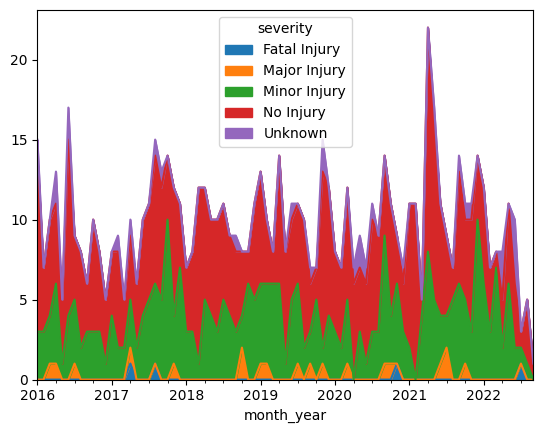

In [27]:
accidents_over_time.plot.area()

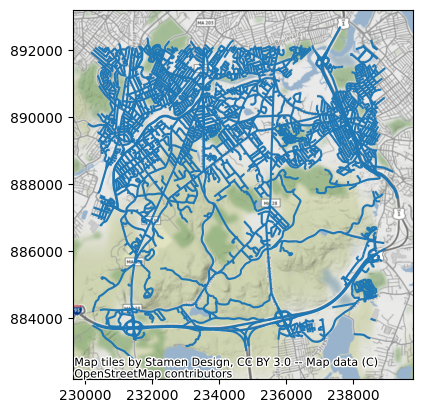

In [28]:
milton_roads_df = gpd.read_file("../data/raw/MassDOT_Roads_SHP/EOTROADS_ARC.shp", mask=milton_boundaries)
ax = milton_roads_df.plot()
ctx.add_basemap(ax,crs="EPSG:26986")

In [29]:
milton_roads_df.head()

STREETNAME  CLASS  ADMIN_TYPE RT_NUMBER ALTRTNUM1 ALTRTNUM2  \
0  PACELLA PARK DRIVE      5           0       NaN       NaN       NaN   
1    ARLINGTON STREET      5           0       NaN       NaN       NaN   
2      HARLAND STREET      5           0       NaN       NaN       NaN   
3      WOODMERE DRIVE      5           0       NaN       NaN       NaN   
4      WOODMERE DRIVE      5           0       NaN       NaN       NaN   

  ALTRTNUM3  ALTRTNUM4  ALTRT1TYPE  RDTYPE  ...   RPA   RTA MILE_COUNT AADT  \
0       NaN        NaN           0       5  ...  MAPC  MBTA          0    0   
1       NaN        NaN           0       5  ...  MAPC  MBTA          0    0   
2       NaN        NaN           0       5  ...  MAPC  MBTA          0    0   
3       NaN        NaN           0       5  ...  MAPC  MBTA          0    0   
4       NaN        NaN           0       5  ...  MAPC  MBTA          0    0   

   AADT_YEAR AADT_DERIV LENGTH_MI    LENGTH_FT   SHAPE_LEN  \
0          0          0  0.035725   188.627991   57.493927   
1          0          0  0.228811  1208.124179  368.236986   
2          0          0  0.025421   134.223842   40.911509   
3          0          0  0.021975   116.026405   35.364919   
4          0          0  0.219525  1159.089475  353.291178   

                                            geometry  
0  LINESTRING (237063.940 883948.684, 237063.085 ...  
1  LINESTRING (231106.734 890388.625, 231113.016 ...  
2  LINESTRING (233820.895 887395.682, 233830.778 ...  
3  LINESTRING (231667.596 888062.852, 231666.406 ...  
4  LINESTRING (231638.570 888082.893, 231631.157 ...  

[5 rows x 71 columns]

<Axes: >

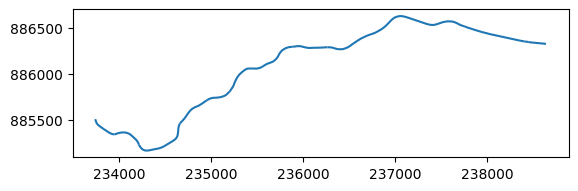

In [30]:
chickatawbut_road = milton_roads_df[milton_roads_df.STREETNAME=="CHICKATAWBUT ROAD"].dissolve()
chickatawbut_road.plot()

<Axes: >

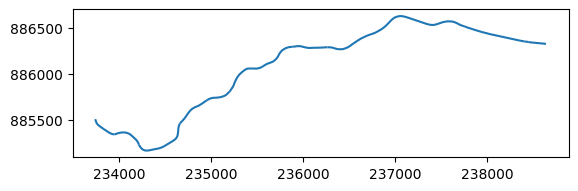

In [31]:
chickatawbut_road.dissolve().plot()

<Axes: >

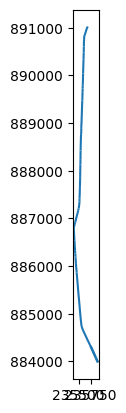

In [32]:
randolph_ave = milton_roads_df[milton_roads_df.STREETNAME=="RANDOLPH AVENUE"].dissolve()
randolph_ave.plot()

<Axes: >

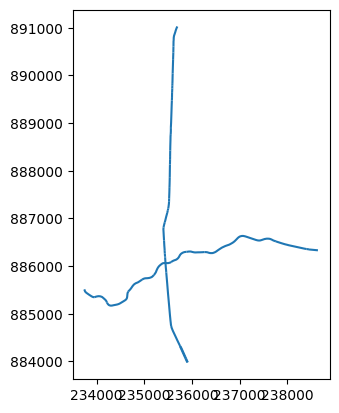

In [33]:
pd.concat([randolph_ave, chickatawbut_road]).plot()

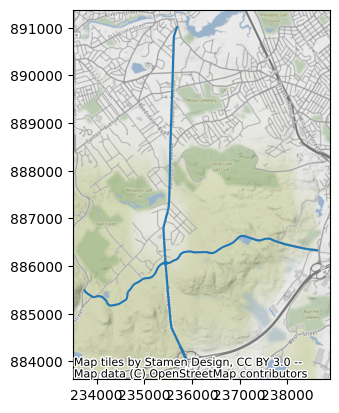

In [34]:
randolph_chickatawbut_intsct = randolph_ave.geometry.intersection(chickatawbut_road.geometry).buffer(50)
ax = pd.concat([randolph_ave, chickatawbut_road]).plot()
ax = randolph_chickatawbut_intsct.plot(ax=ax)
ctx.add_basemap(ax, crs="EPSG:26986")

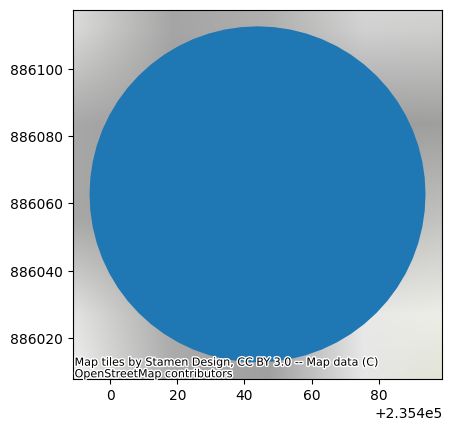

In [35]:
ax = randolph_chickatawbut_intsct.plot()
ctx.add_basemap(ax, crs="EPSG:26986", zoom=12)

In [36]:
randolph_chickatawbut_intsct

0    POLYGON ((235493.881 886062.686, 235493.641 88...
dtype: geometry

In [37]:
193.18/647

0.29857805255023184